# Genre analysis

In this notebook, we explore the movie genres distribution throughout the cinema history, and how it relates to their associated grades and revenue. We will show that some genres are preferable while others are to avoid if we want to aim at the highest rating possible. We will explain how the genre choice in the movie industry seem to be driven by the profits much more than by the ratings. Finally, we will explore the difference between 2 time windows in terms of RRB (rating, revenue, budget) and movie genre to refine our previous observation that ratings dropped over time.

## Table of contents 
- [1. Genre prevalence](#1.-Genre-prevalence)
- [2.  Creation of dummies for genres](#2.-Creation-of-dummies-for-genres)
- [3.  RRB distribution by genre](#3.-RRB-distribution-by-genre)
    - [3.1.  Rating across genre](#3.1.-Rating-across-genre)
    - [3.2.  Budget across genre](#3.2.-Budget-across-genre)
    - [3.3.  Revenue across genre](#3.3.-Revenue-across-genre)
- [4.  Linear regression: average ratings and revenue](#4.-Linear-regression:-average-ratings-and-revenue)
    - [4.1.  Rating](#4.1.-Rating)
    - [4.2.  Log revenue](#4.2.-Log-revenue)
    - [4.3.  Log revenue](#4.3.-Log-budget)
- [5.  Genre across time](#5.-Genre-across-time)
- [6.  Conclusion](#6.-Conclusion)



A lot of functions used here can be found in the [helpers.py](helpers.py)

Imports:

In [1]:
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
import sklearn
from matplotlib import cm
# import webcolors
import ast
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from helpers import *

%load_ext autoreload
%autoreload 2

Let's import the data:

In [2]:
df_movie = pd.read_csv("data/Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

## 1. Genre prevalence

As such, our movie genres are defined as a combination of max 3 individual genres.
Let's display the 20 most represented genre combinations:

In [3]:
data = df_movie.copy()
data.dropna(subset=['Movie genres names'], inplace=True)
count_genre = data['Movie genres names'].value_counts()

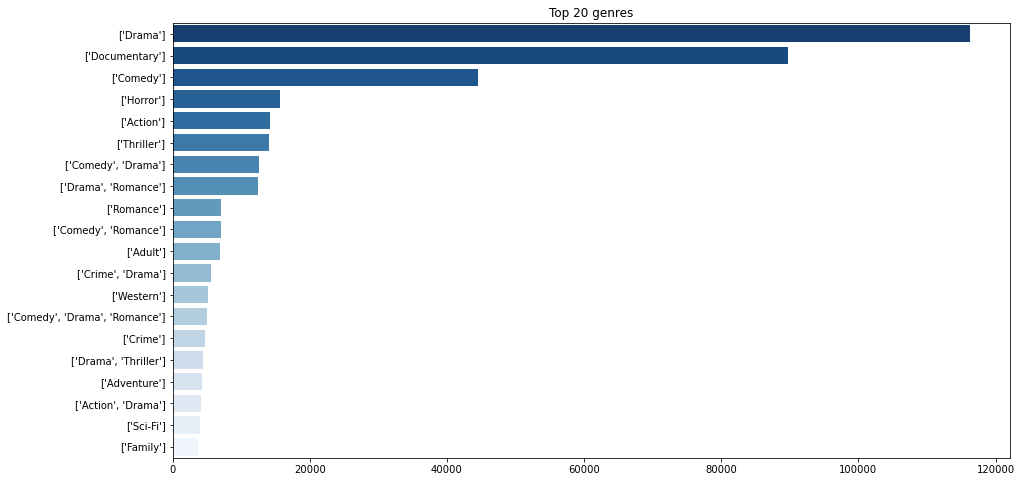

In [4]:
hbarplot(count_genre.values[0:20], count_genre.index[0:20], title='Top 20 genres')

We observe that drama, documentary and comedy movies occupy a huge portion of the distribution. Comedy-Drama or Drama-Romance are the most represented 2-genres movies.

To avoid the combinatorial explosion that is created by the association of all the genres (which would also prevent a relevant statistical analysis), we will treat them independently from here on. However, proceeding like this comes with the loss of the information of these genres combinations.

Let's observe the distribution of individual genres:

In [5]:
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
counts = pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

To enable a convenient tracking of genres troughout to figures, we will associate a color to each of them.

In [6]:
# create a color code for genres to help vizualisation
rainbow = cm.get_cmap('rainbow', len(counts.index))
cmap = rainbow(np.linspace(0,1,len(counts.index)))
rgb_colors = {genre : cmap[i][:-1] for i, genre in enumerate(counts.index)}
hex_colors = {k : "#%02x%02x%02x" % (int(c[0]*255), int(c[1]*255), int(c[2]*255))
                for k, c in zip(rgb_colors.keys(), rgb_colors.values())}

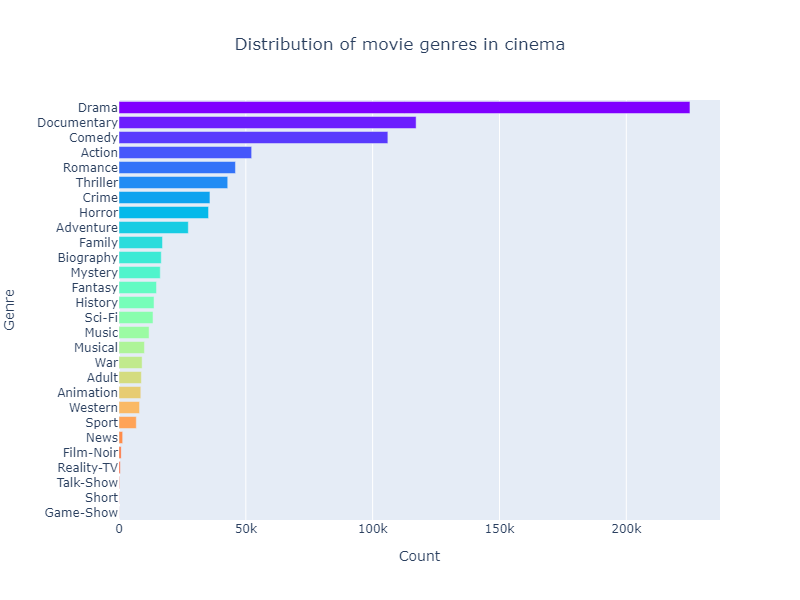

In [7]:
df = pd.DataFrame({'Count': counts.values, 'Genre': counts.index})
# here we need to pass the colors in HEX format
plotly_barplot(df, 'Count', 'Genre', [hex_colors[genre] for genre in counts.index],
                title = 'Distribution of movie genres in cinema',
                filename= 'overall_genre_distr', save = True)

As implemented, the rainbow pattern follows the movie genre distribution in cinema in general.

Suddenly, genres which are most often combined with another appear to have more prevalence than before, such as Crime. This is an advantage of this way of analysing the data. We observe that a few series-like genres appear; this comes from the IMDB platform enabling these genres for movies, and this will not come into play in our analysis due to their low number.

## 2. Creation of dummies for genres

Here we will split the genres combinations into subunits of single genre. 
This can be done through the help of dummies; each movie can have a non-zero genre entry for up to 3 genres.

We will relate these genres to rating, budget and revenue. Therefore, we will need to work on a subset of movies for which this data is available.

In [8]:
data = df_movie[['Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()

In [9]:
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
counts = pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

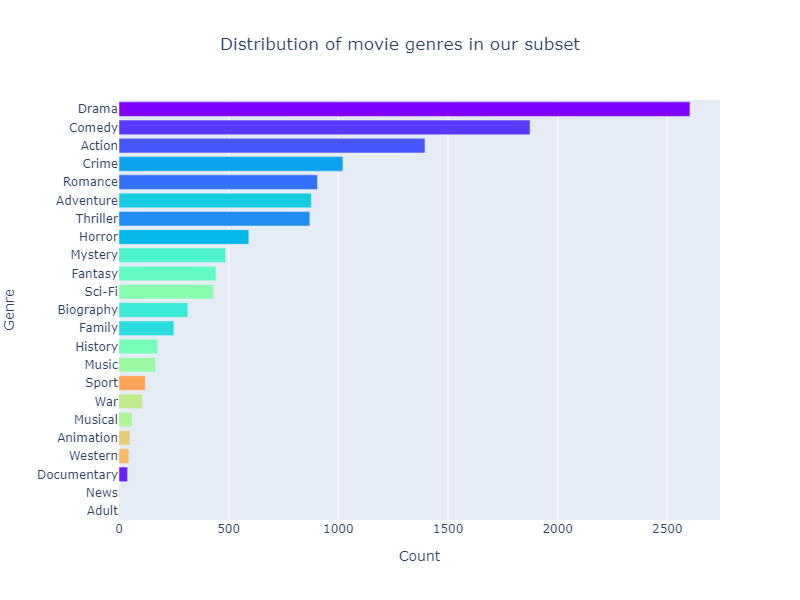

In [10]:
df = pd.DataFrame({'Count': counts.values, 'Genre': counts.index})
plotly_barplot(df, 'Count', 'Genre', [hex_colors[genre] for genre in counts.index],
                title = 'Distribution of movie genres in our subset')

We have 23 remaining categories in our subset. We observe that the distribution changes only slightly, except for documentary which is much less represented. This shift might be due to that fact that some genre are less reported in terms of revenue or budget in data. However, we only need to have enough sample in those categories to reliably relate them to the "whole cinema" distribution and our question.

The drama is still leading with more that 2600 movies, followed by comedy and action.

Let's create the dummy variables.

In [11]:
data, genre_names = incorporate_genre_dummies(data)

# we had to rename a genre by creating the dummies, and we duplicate here its entry in the colormap
hex_colors['SciFi'] = hex_colors['Sci-Fi']
rgb_colors['SciFi'] = rgb_colors['Sci-Fi']

We rename some variables for easier use later

In [12]:
#data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data.rename(columns={'Movie genres names' : 'genre','inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)

Only two Adult and News movies are not enough to represent their categories, so we remove them. Music and Musical represent similar genres of movies; therefore, we combine them.

In [13]:
# Adult, News
data = data.drop(columns = ['Adult','News'])
genre_names.remove('Adult')
genre_names.remove('News')

# Music, Musical
data['Music'] = np.logical_or(data['Music'], data['Musical']).astype(int)
data = data.drop(columns = ['Musical'])
genre_names.remove('Musical')

Let's add columns for the logarithm of the revenue and budget for analysis (coherent with previous analysis) later on.

In [14]:
data['log_revenue'] = np.log(data['corr_revenue'])
data['log_budget'] = np.log(data['corr_budget'])

In [15]:
data.head(2)

,genre,averageRating,corr_budget,corr_revenue,Action,Adventure,Animation,Biography,Comedy,Crime,...,Music,Mystery,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,"['Crime', 'Drama']",7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,15.361558,15.336866
225,"['Action', 'Comedy']",7.0,7.431127e+07,2.694641e+08,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,19.411946,18.123773


## 3. RRB distribution by genre

Let's have a look at the RRB distributions by genre.

### 3.1. Rating across genre

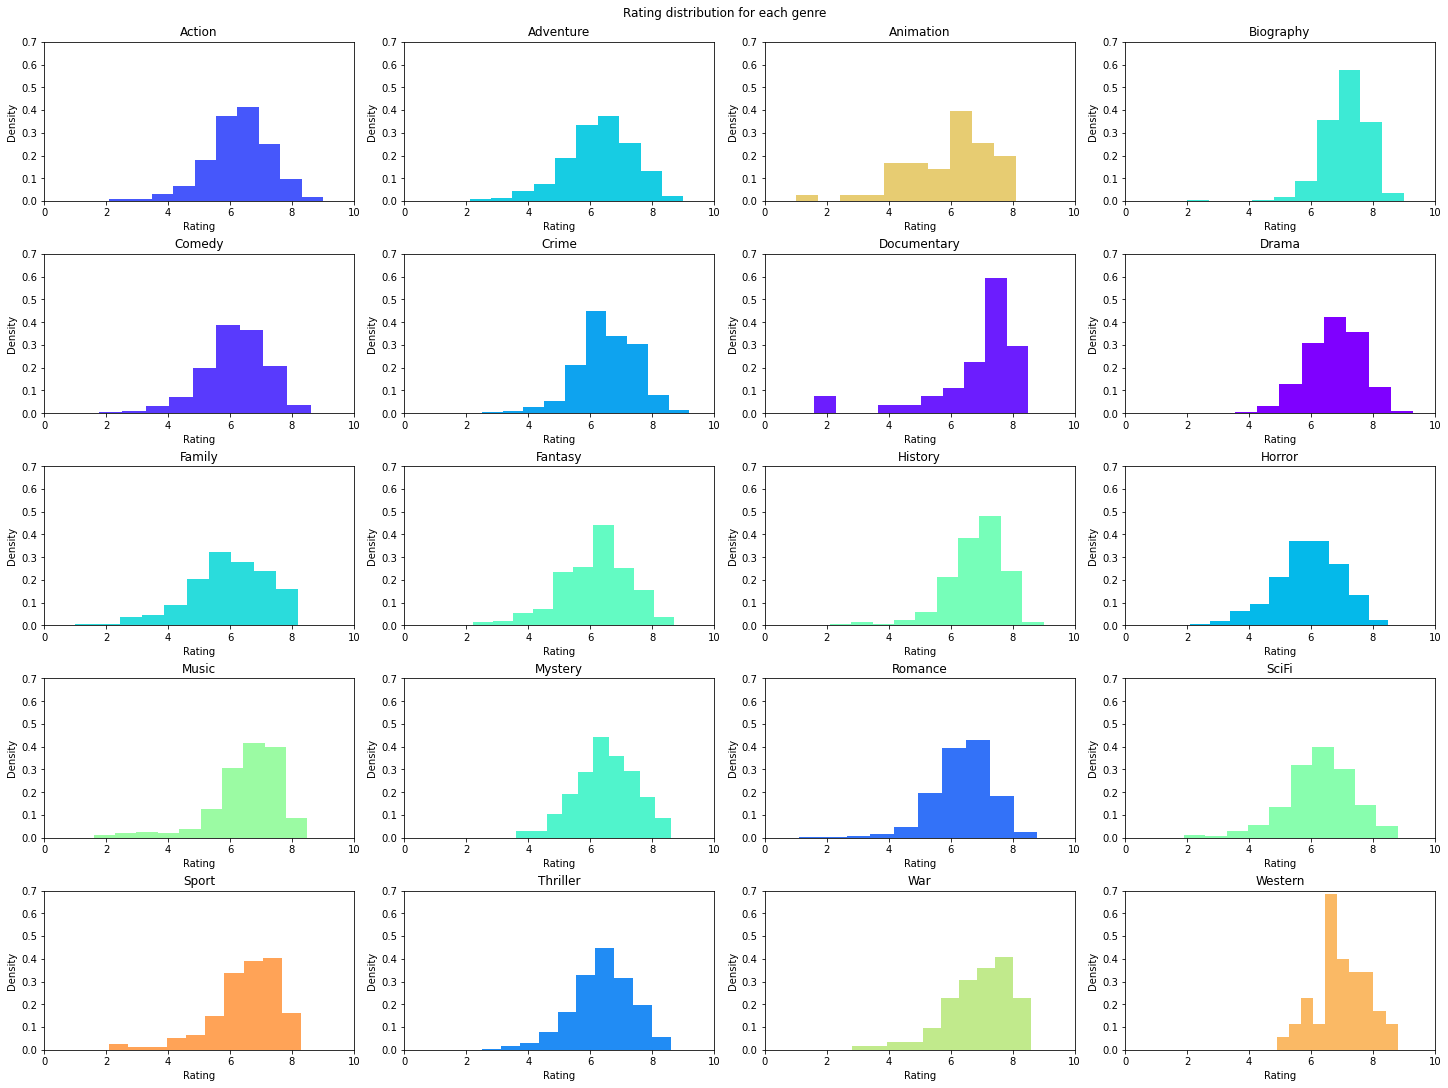

In [16]:
hist_subplots(data, 'averageRating', genre_names, hex_colors, 'Rating distribution for each genre', 'Rating', (0,10), (0,0.7) )

We remark that in general the distributions seem to be heavy-tailed.

Reminder: the rating are in the range $[0,10]$, where $10$ is the best score and $0$ is the worst score.

Let's plot the 95% confidence interval around the mean for these distributions:

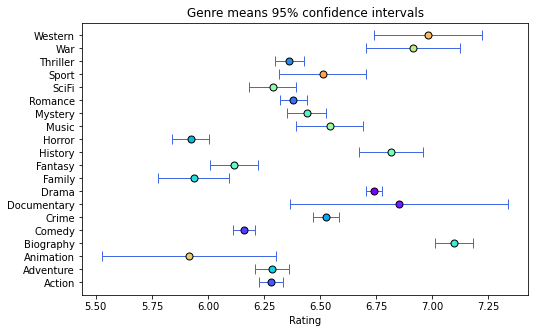

In [17]:
CIs = []    
    
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='averageRating')
    
plot_CIs(CIs, genre_names, m_colors = [rgb_colors[genre] for genre in genre_names], xlabel = 'Rating')

Biography, news, war and western are better rated than the other categories.
**Horror, Fantasy, Family and Animation** have the lowest ratings.

### 3.2. Budget across genre


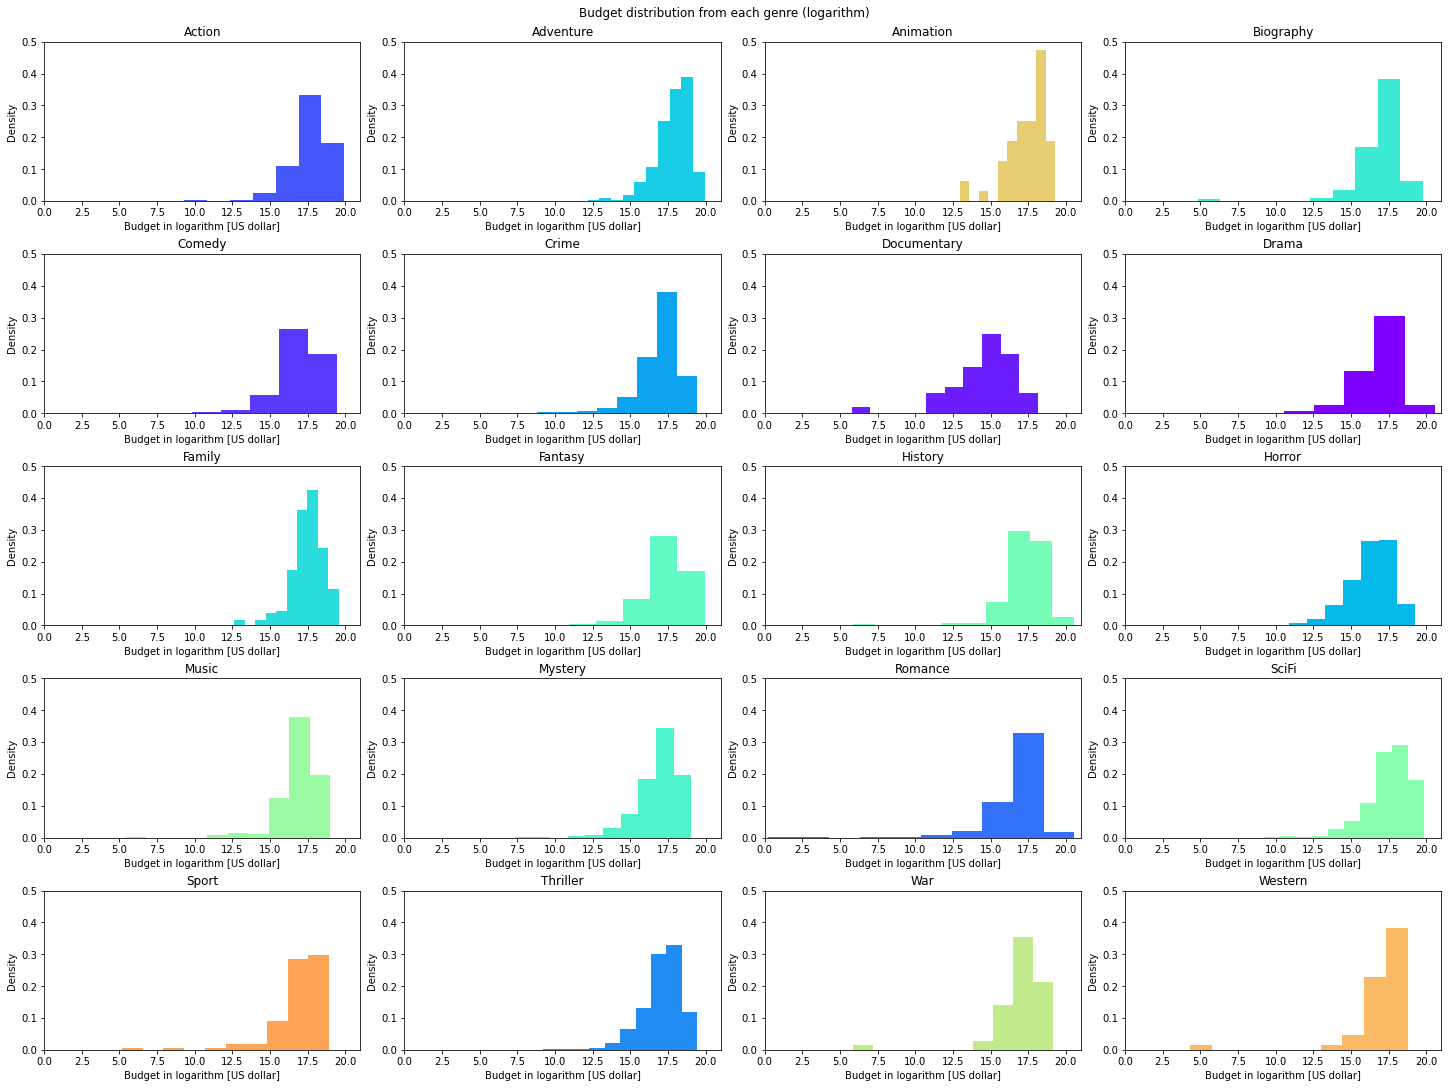

In [18]:
hist_subplots(data, 'log_budget', genre_names, hex_colors, 'Budget distribution from each genre (logarithm)', 'Budget in logarithm [US dollar]', (0,21), (0,0.5))

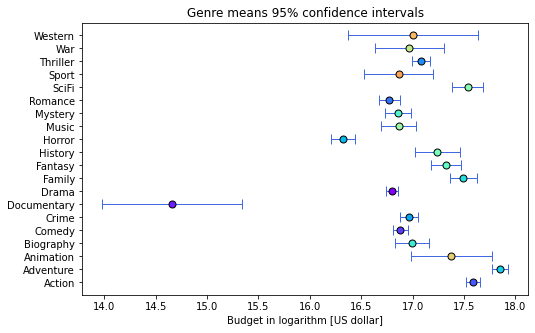

In [19]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_budget')
    
plot_CIs(CIs, genre_names, m_colors=[
         rgb_colors[genre] for genre in genre_names], xlabel='Budget in logarithm [US dollar]')


If we look that the mean value of the log budget, we remark that documentaries have low budget compared to all the others.
**Adventure** movies have significant higher budget than the others. 

### 3.3. Revenue across genre


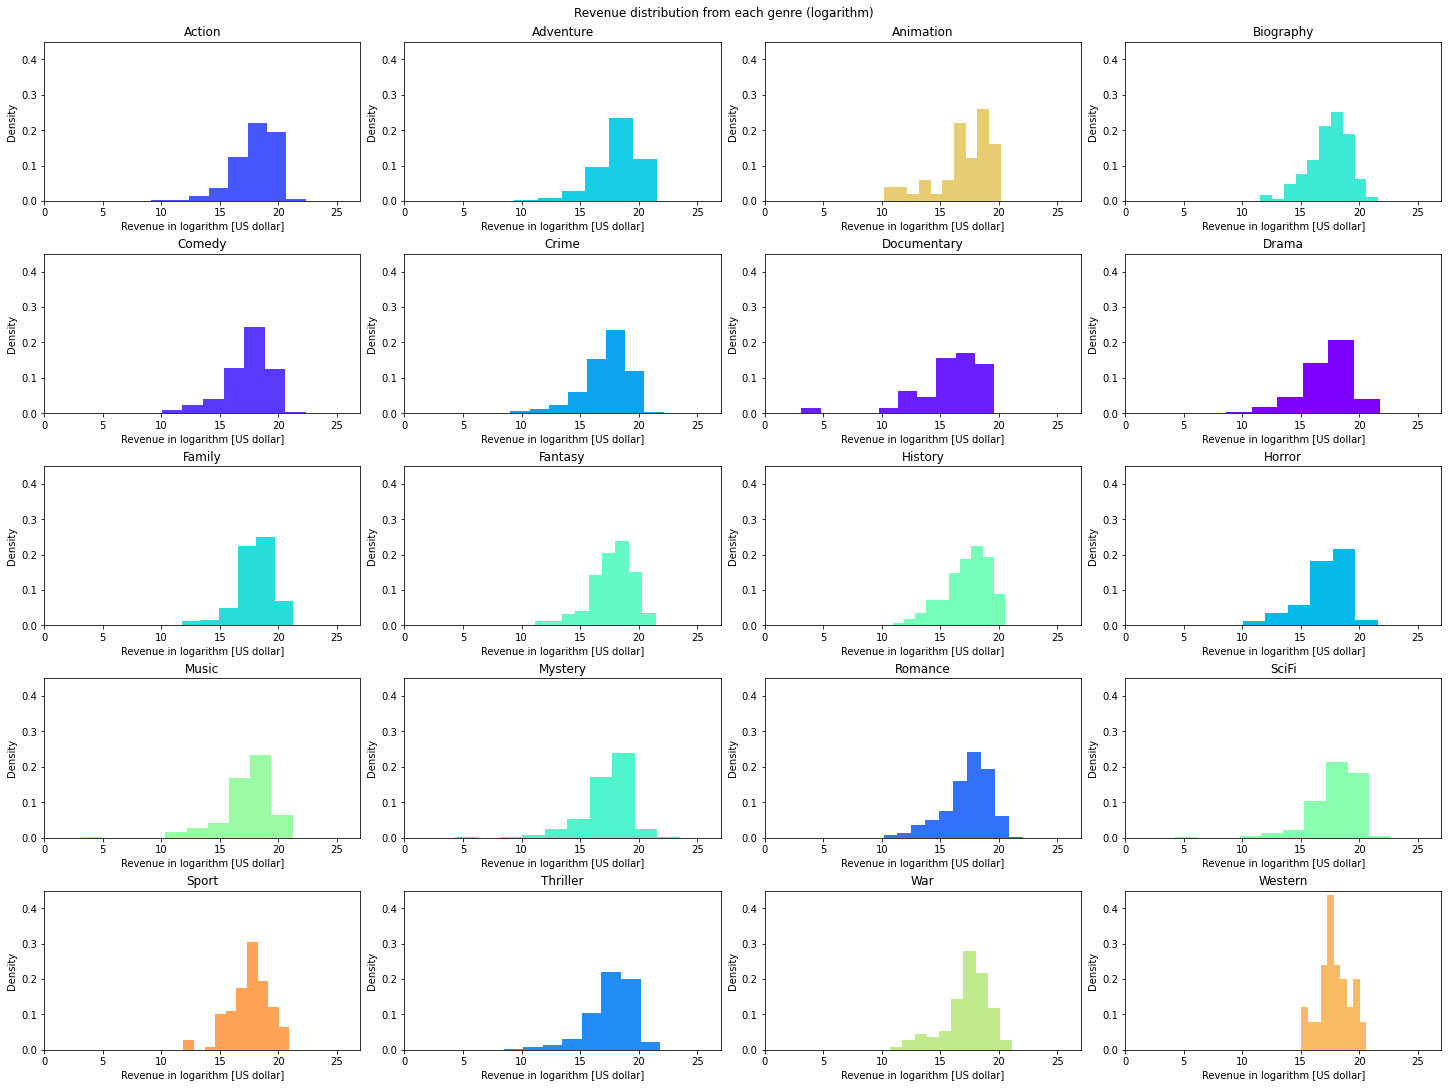

In [20]:
hist_subplots(data, 'log_rehttp://localhost:8890/notebooks/OneDrive/Documenti/GitHub/ada-2022-project-nolemonnomelon/Genre.ipynb#3.3-Revenue-across-genrevenue', genre_names, hex_colors, 'Revenue distribution from each genre (logarithm)', 'Revenue in logarithm [US dollar]', (0,27), (0,0.45))

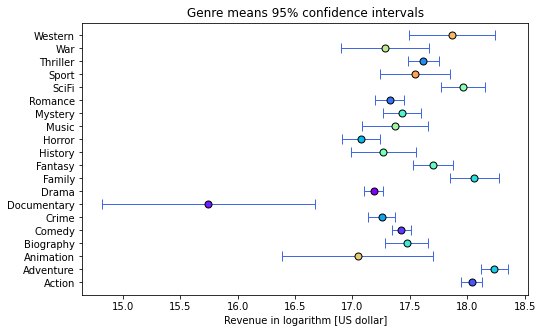

In [21]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_revenue')
    
plot_CIs(CIs, genre_names, m_colors = [rgb_colors[genre] for genre in genre_names], xlabel = 'Revenue in logarithm [US dollar]')

**Adventure, Action, Western, Family and Sci-fi** generate higher revenues than the others. **Documentaries** have a significantly lower revenue than the others


If we put these 3 RRB measures in perspective, general patterns stand out:
* Documentaries have a the lowest budget and revenue, but are very well graded, which defines it as a well-suited genre for the situation we're in.
* (+) Western (and War to a lesser extent) generate high revenue and are well-graded.
* (-) Horror, Animation and Fantasy generate low revenue and have bad ratings
* (?) Family, Action and Adventure have generate the highest revenues, but have low grades in general

Despite that, Horror movies are fairly represented in cinema, much more than Western and War movies. Why is that ? What drive genre prevalence in the cinema industry ?

We made the hypothesis that profit, which we define here as revenue - budget (not in log form), is driving the genre choice in the industry. Let's visualize that measure in a barplot:

In [64]:
genres = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
        'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
        'Romance', 'SciFi', 'Sport', 'Thriller', 'War', 'Western']
profit_CI_by_genre = np.array([bootstrap(data[data[genre] == 1]['corr_revenue'] - \
                                data[data[genre] == 1]['corr_budget'], \
                                    len(data), also_median = True) for genre in genres])

We will look at the median:

In [65]:
profit_CI_median = profit_CI_by_genre[:,[1,4,5]]
df = pd.DataFrame({'Median': profit_CI_median[:,0], 'Genre': genres,
                'low' : profit_CI_median[:,1], 'high' : profit_CI_median[:,2]})

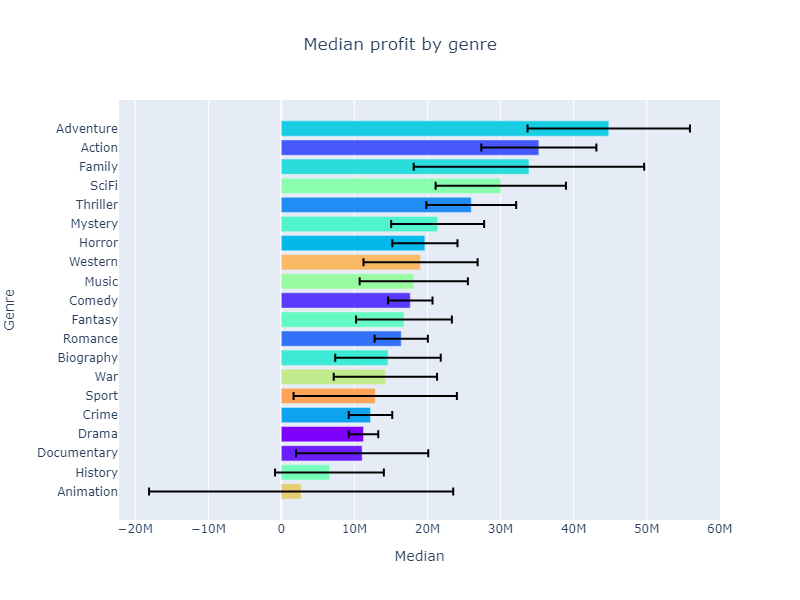

In [66]:
# here we need to pass the colors in HEX format
plotly_barplot(df, 'Median', 'Genre', [hex_colors[genre] for genre in genres],
                title = 'Median profit by genre', err_bar=True,
                filename= 'median_profit_by_genre', save = True)

The profit might explain the prevalence of **horror and fantasy** despite a low revenue and ratings, as well as the prevalence of **Adventure, Action and Family**, despite their low ratings.

However, the place of **Documentary** (and other genres) in the plot above does not justify its huge prevalence in the cinema industry, and other factors, not analysed here, must contribute to it. We cannot really conclude on this, but it demonstrates the influence of factors we do not have in our dataset.

Similarly, we can compute the rentability of a genre by talking the ratio revenue/budget, which is the difference log revenue - log budget to avoid using a genre that will likely ruin us. Great to make a good movie, but we cannot sink our company !

In [67]:
profit_CI_by_genre = np.array([bootstrap(data[data[genre] == 1]['log_revenue'] - \
                                data[data[genre] == 1]['log_budget'], \
                                    len(data), also_median = True) for genre in genres])

In [68]:
profit_CI_median = profit_CI_by_genre[:,[1,4,5]]
df = pd.DataFrame({'Median': profit_CI_median[:,0], 'Genre': genres,
                'low' : profit_CI_median[:,1], 'high' : profit_CI_median[:,2]})

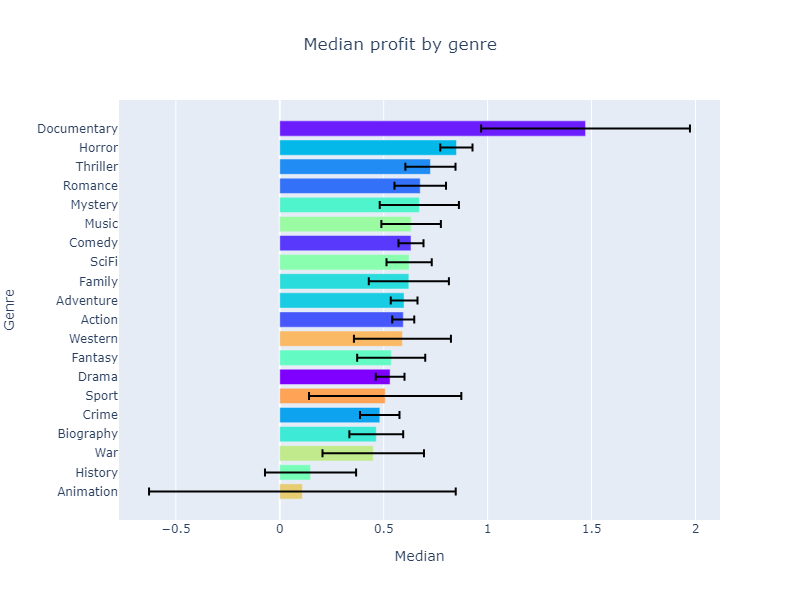

In [69]:
# here we need to pass the colors in HEX format
plotly_barplot(df, 'Median', 'Genre', [hex_colors[genre] for genre in genres],
               title='Median profit by genre', err_bar=True,
               filename='median_profit_by_genre', save=True)


Now, we know that despite generating low revenue, **Documentaries** are actually the genre with the higher rentability ! **Horror** are also safe to make financially, despite obtaining low ratings, along with other genres whose prevalence can be explained that way !

## 4. Linear regression: average ratings and revenue


Let's now try to perform some linear regressions in order to regress out the genres that influence them the most. This part will duplicate the observations of the previous section, and also give a clearer statistical significance.

### 4.1. Rating

Let's do a regression of rating using the 23 genres we have.

In [28]:
mod = smf.ols(formula="averageRating ~ Action + Adventure +\
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Mystery +\
       Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
# print(res.summary())

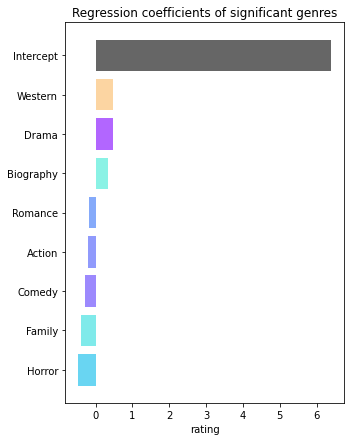

In [29]:
# correction for multiple testing hardoded
barplot(res, 'rating', significant_only = True, cmap = rgb_colors)

**Biography, Drama, Western** are significantly driving the grades upwards, while **Action, Comedy, Family and Horror** drive it downwards.

We observe that the intercept is by far the highest determinant of the absolute rating (and it will be the same for budget and revenue). It is expected, because a huge amount of factors determine the quality or rentability of movies, some of which are not even measurable. Our analysis only focuses on how few simple features influence these results.

(But what if we keep the genre together without using dummies varibles?)

In [30]:
# mod = smf.ols(formula="averageRating ~ genre", data=data)

# res = mod.fit()
# print(res.summary())

(We obtain a higher R square! The genre not split better capture the rating!)

### 4.2. Log revenue

We can perform the same analysis with logarithm of the revenue as response variable.

In [31]:
mod = smf.ols(formula="log_revenue ~ Action + Adventure + \
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Mystery +\
       Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
# print(res.summary())

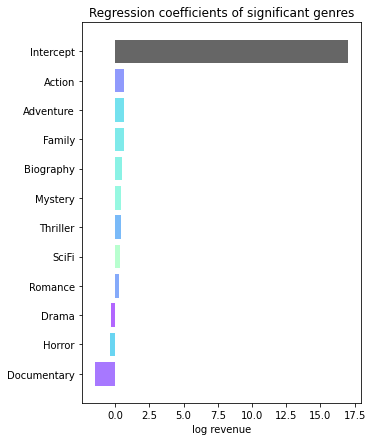

In [32]:
# correction for multiple testing hardoded
barplot(res, 'log revenue', significant_only=True, cmap=rgb_colors)


**Action, Adventure, Biography, and Family** (Mystery, Thriller, Sci-Fi to a lesser extent) are significantly driving the revenue upwards, while **Documentary** (especially !), **Drama and Horror** drive it downwards.

The genres have lower effect on revenue than on rating.

### 4.3. Log budget

We can perform the same analysis with logarithm of the budget as response variable.

In [33]:
mod = smf.ols(formula="log_budget ~ Action + Adventure + \
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Mystery +\
       Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
# print(res.summary())

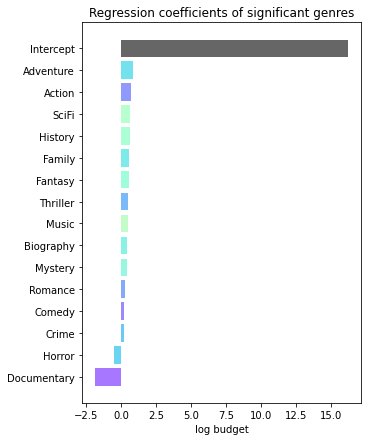

In [34]:
# correction for multiple testing hardoded
barplot(res, 'log budget', significant_only=True, cmap=rgb_colors)


As expected, **Documentary and Horror** predict a significantly lower budget, while **Adventure, Action and Sci-Fi** (the 3 of them especially) predict a higher budget.

In [35]:
# mod = smf.ols(formula="log_revenue ~ Comedy*Romance + \
#                                     Comedy*Drama + \
#                                     Drama*Romance ", data=data)

# res = mod.fit()
# print(res.summary())

In [36]:
# barplot(res, figsize=(3,5))

*(Interestingly, for very common genre associations, we observe that their combination has a positive effect on revenue, while the genre alone tend to provoke a decrease. But the R value decreased.)*

*(Again let's try to use the original genres:)*

In [37]:
# mod = smf.ols(formula="log_revenue ~ genre ", data=data)

# res = mod.fit()
# print(res.summary())

*(Again, the R squred is much higher! It  is better to use to original genre.)*

*(### Boxplots)*

In [38]:
# budget, revenue, rating = list(), list(), list()
# for genre in genre_names:
#     budget.append(data[data[genre] == 1]['log_budget'])
#     revenue.append(data[data[genre] == 1]['log_revenue'])
#     rating.append(data[data[genre] == 1]['averageRating'])

In [39]:
# fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6))
# axs[0].boxplot(budget, labels=genre_names, vert = False)
# axs[0].set_xlabel('log budget')
# axs[1].boxplot(revenue, labels=genre_names, vert = False)
# axs[1].set_xlabel('log revenue')
# axs[2].boxplot(rating, labels=genre_names, vert = False)
# axs[2].set_xlabel('rating')
# plt.xticks(rotation=90)
# plt.show()

### Low budget and high revenue 
<span style="color:blue"> Ratio stuff was moved to last section, and the rest is repetition of clustering.ipynb or exploratory.ipynb
#### Scatter plot

Let's try to look at region where the budget is low and the revenue is high.
For this we use a linear regression and we select a threshold for detecting the low budget.

In [40]:
# mod = smf.ols(formula="log_revenue ~ log_budget ", data=data)
# res = mod.fit()

In [41]:
# res.summary()

In [42]:
# coef = res.params.values

In [43]:
# fig = sns.scatterplot(x=data.log_budget,y=data.log_revenue)
# fig.axline((0,coef[0]), slope=coef[1], color='red', label='Linear fit',linestyle='dashed')
# plt.show()

Let's select the movies with log budget lower than 7. 
In this region we see that all the movies are above the regression line, therefore they have a quite high revenue compared to the budget.

In [44]:
# low_budget = data.loc[data.log_budget <= 7]

In [45]:
# df = low_budget.copy()
# df = df.drop(columns = ['genre','averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

In [46]:
# genres = df.columns
# tot = []
# for gen in genres:
#     tot.append(sum(df[gen]))
# plt.figure(figsize=(15,8))
# ax = sns.barplot(x=tot, y=genres).set(title='Genres with log budget <= 7')
# plt.show()

Above we see a representation of the genre in the case of low budget.
There are a lot of drama movies, this could be due by the fact that there are a lot of drama movies in the datset.
By dividing the values here by the total number of movie sin each categories we should see a bit better the situation.

In [47]:
# all_tot = []
# for gen in genres:
#     all_tot.append(sum(data[gen]))

In [48]:
# plt.figure(figsize=(15,8))
# ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres low budget ratio all')
# plt.show()

Now it seems that documentary and western are quite present in this low budget region.

We focused on low budget movies but now we can also try to look at movies that earn 10 times more than their budget.

In [49]:
# high_revenue = data.loc[data.log_revenue >= (np.log(10) + data.log_budget)]
# #high_revenue = data.copy()

In [50]:
# df = high_revenue.copy()
# df = df.drop(columns = ['genre','averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

In [51]:
# genres = df.columns
# tot = []
# for gen in genres:
#     tot.append(sum(df[gen]))
# plt.figure(figsize=(15,8))
# ax = sns.barplot(x=tot, y=genres).set(title='Genres with revenue 10 times bigger than budget')
# plt.show()

In [52]:
# plt.figure(figsize=(15,8))
# ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres with revenue 10 times bigger that budget ratio all')
# plt.show()

By comparing the revenue with the budget (revenue is 10x higher than the budget), the proportion of documentary movies is the highest, followed by horror and Western movies.

## 5. Genre across time
We want to observe if some evolution occurs across time. Because of this, we will split the data in two caterogies depending of the movie's year: before 2000 and after 2000.

In [53]:
data_time = df_movie[['Movie genres names', 'Movie release date', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()
data_time, genre_names = incorporate_genre_dummies(data_time)
data_time.rename(columns={'Movie genres names' : 'genre', 'Movie release date':'date', 'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data_time['log_revenue'] = np.log(data_time['corr_revenue'])
data_time['log_budget'] = np.log(data_time['corr_budget'])
data_time.head(3)

,genre,date,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,"['Crime', 'Drama']",2014.0,7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15.361558,15.336866
225,"['Action', 'Comedy']",2015.0,7.0,7.431127e+07,2.694641e+08,1,0,0,0,0,...,0,0,0,0,0,0,0,0,19.411946,18.123773
446,['Comedy'],2014.0,6.7,3.891662e+06,1.236175e+06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14.027532,15.174347


In [54]:
data_time = data_time.drop(columns = ['Adult','News'])
genre_names.remove('Adult')
genre_names.remove('News')
data_time['Music'] = np.logical_or(data_time['Music'], data_time['Musical']).astype(int)
data_time = data_time.drop(columns = ['Musical'])
genre_names.remove('Musical')

In [55]:
# split data in two periods: from 1959 to 2000 and from 2000 to 2021.
old_movies = data_time[data_time.date < 2000]
recent_movies = data_time[data_time.date >= 2000]

In [56]:
# number of movie genres in the first period (before 2000) = []
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in old_movies.genre]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          1056
Comedy          793
Action          512
Crime           453
Thriller        371
Romance         356
Adventure       324
Horror          261
Mystery         183
Sci-Fi          174
Fantasy         172
Biography       104
Family          103
Music            73
History          61
War              56
Sport            53
Western          33
Musical          27
Animation         7
Documentary       4
Adult             2
dtype: int64

In [57]:
# number of movie genres in the second period (after 2000 included)
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in recent_movies.genre]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          1547
Comedy         1081
Action          883
Crime           568
Adventure       553
Romance         549
Thriller        499
Horror          331
Mystery         303
Fantasy         270
Sci-Fi          258
Biography       210
Family          147
History         116
Music            94
Sport            67
War              50
Animation        43
Documentary      35
Musical          33
Western          12
News              2
dtype: int64

Here, the first popular genres seem to be similar. Indeed, Drama, Comedy, Action and Crime remain all the 4 more represented movie genres in both periods. 

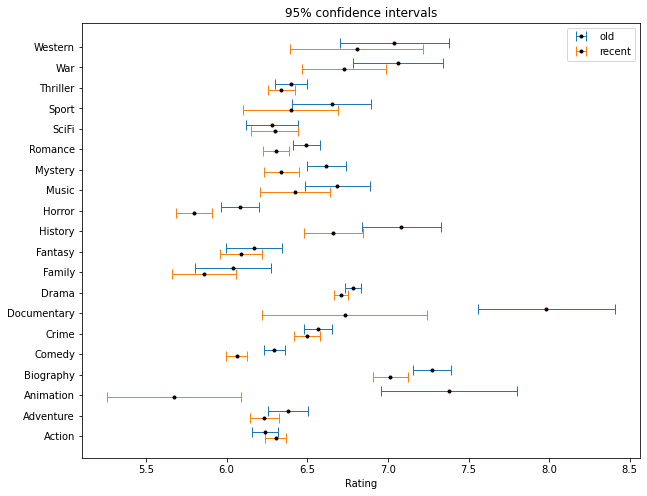

In [58]:
# Confidence interval according to the ratings
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='averageRating')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='averageRating')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Rating')
plt.show()

Some genres show significant difference between the periods. In general, the old movies are better rated except for the action movies (but non-significant). **Romance, Mystery, Horror, History, Documentary, Comedy, Biography, and Animation** movies were significantly better rated before 2000. Are the movies worse, or is the population more critical? 

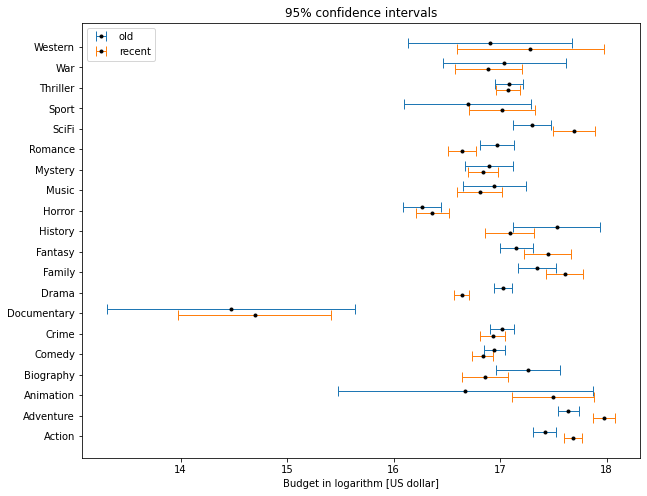

In [59]:
# Confidence interval according to the budget
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_budget')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_budget')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Budget in logarithm [US dollar]')
plt.show()

**Science fiction, Adventure, and Action** movies show an significant increase in budget, whereas **Romance and Drama** movies undergo a significant decrease in their budget. 

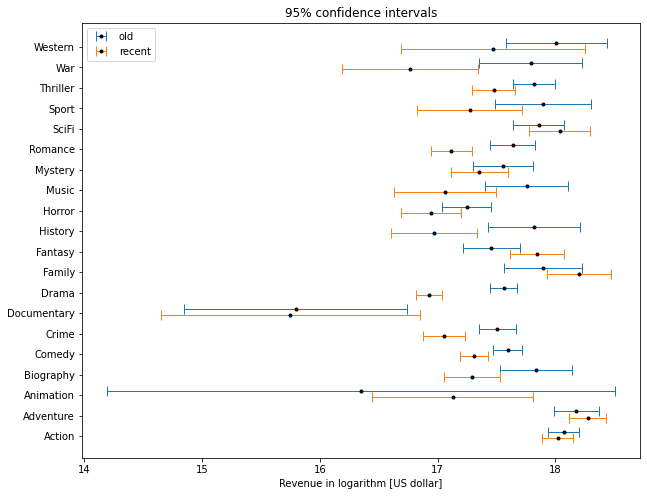

In [60]:
# Confidence interval according to the revenue
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_revenue')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_revenue')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Revenue in logarithm [US dollar]')
plt.show()

No movie show significant increase in their revenue, whereas **Romance, History, Drama, Crime, Comedy, and Biography** movies have a significant decrease.
Thus, a significant increase in budget (such as for Action, Adventure, and Science fiction movies) does not mean a significant increase in the revenue.

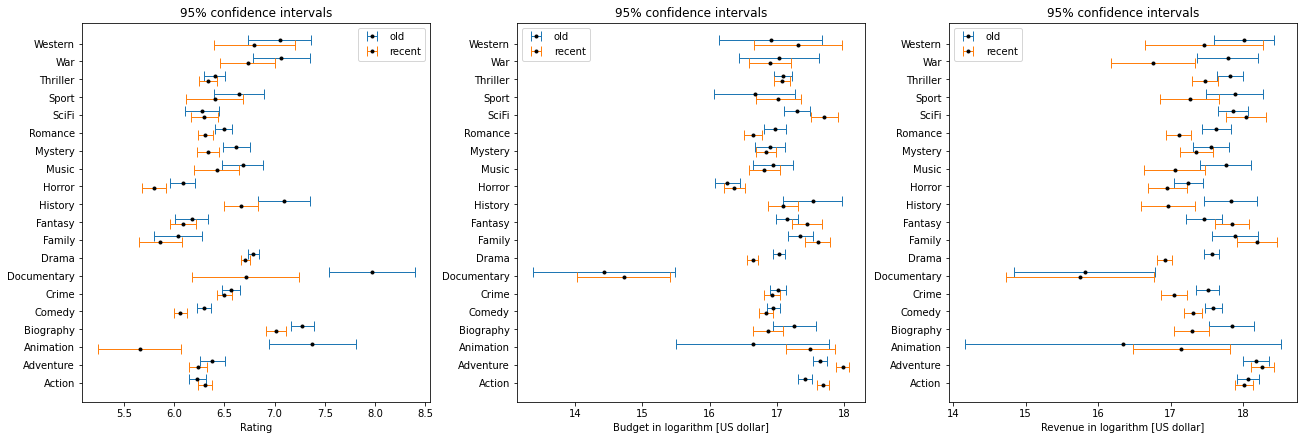

In [61]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6), constrained_layout=True)
# Rating
recent_CIs = []    
old_CIs = []     
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='averageRating')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='averageRating')    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Rating', n = 0, fig=fig, axs=axs)

# Budget
recent_CIs = []    
old_CIs = []    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_budget')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_budget')
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Budget in logarithm [US dollar]',  n = 1, fig=fig, axs=axs)

# Revenue
recent_CIs = []    
old_CIs = []    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_revenue')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_revenue')
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Revenue in logarithm [US dollar]', n = 2, fig=fig, axs=axs)



In [62]:
old_movies['diff_log_rev_bud'] = old_movies.log_revenue-old_movies.log_budget
recent_movies['diff_log_rev_bud'] = recent_movies.log_revenue-recent_movies.log_budget
old_movies.head(2)

C:\Users\loris\AppData\Local\Temp\ipykernel_2684\1455148246.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\loris\AppData\Local\Temp\ipykernel_2684\1455148246.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,genre,date,averageRating,corr_budget,corr_revenue,Action,Adventure,Animation,Biography,Comedy,...,Mystery,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget,diff_log_rev_bud
3851,"['Comedy', 'Drama', 'Fantasy']",1993.0,8.1,2.738616e+07,1.333818e+08,0,0,0,0,1,...,0,0,0,0,0,0,0,18.708726,17.125548,1.583178
3858,"['Adventure', 'Drama', 'History']",1995.0,7.7,9.246698e+07,3.091206e+08,0,1,0,0,0,...,0,0,0,0,0,0,0,19.549242,18.342362,1.206880


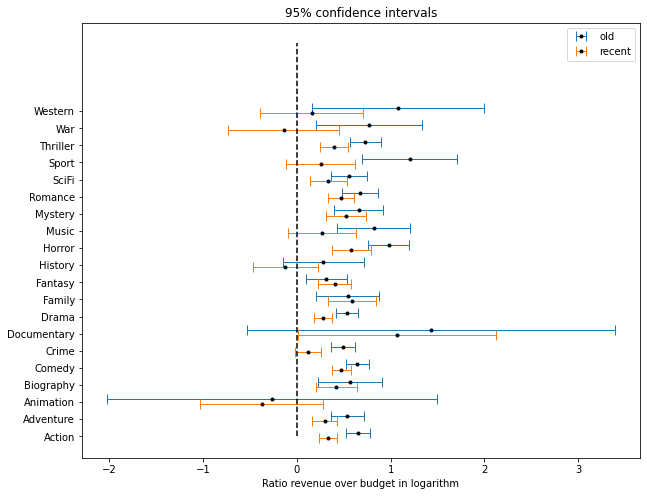

In [63]:
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='diff_log_rev_bud')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='diff_log_rev_bud')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Ratio revenue over budget in logarithm')
plt.vlines(0, 0, 23, linestyle='--', color='black')
plt.show()

In general, the revenue is higher than the budget. No genre shows a significant higher budget (result below zero). **Thriller, Sport, Drama, Crime, and Action** had a significant higher difference between the budget and the revenue during the first period (before 2000). 
**Western, War, Sport, Musical, Music, History, Documentary, Crime, and Animation** movies, do not have significant higher revenue than budget in one of the two periods.  

## 6. Conclusion

Let's recapitulate the main findings of this analysis.

- As shown in the exploratory analysis there is a difference in time across the rating, overall and inside the genres. Concerning the rating, there is a significant difference in the same genre category from the past and the present.
- Documentaries have a the lowest budget and revenue, but are very well graded.
- Horror, Animation and Fantasy generate low revenue and have bad ratings
- Surprisingly a significant increase in budget does not reflect in a significant increase in the revenue across time for the genre.

### Go to [Clustering.ipynb](Clustering.ipynb) to continue the analysis.